In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.3.1


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

Opening a sample file that the text classifier will be learning from.  

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Training model
- 80/20 split

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Reviews with their labels for context. 

In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Removing whitespace, all one case, removing page breaks/punctuation

In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Vectorizing the standardized text 

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [57]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"A young woman suffers from the delusion that she is a werewolf, based upon a family legend of an ancestor accused of and killed for allegedly being one. Due to her past treatment by men, she travels the countryside seducing and killing the men she meets. Falling in love with a kind man, her life appears to take a turn for the better when she is raped and her lover is killed by a band of thugs. Traumatized again by these latest events, the woman returns to her violent ways and seeks revenge on the thugs," according to the DVD sleeve\'s synopsis.<br /><br />Rino Di Silvestro\'s "La lupa mannara" begins with full frontal, writhing, moaning dance by shapely blonde Annik Borel, who (as Daniella Neseri) mistakenly believes she is a werewolf. The hottest part is when the camera catches background fire between her legs. The opening "flashback" reveals her hairy ancestor was (probably) a lycanthropic creature. Ms. Borel is, unfortunately, not a werewolf; she is merely a very

In [56]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print("5173 ---> ",vectorize_layer.get_vocabulary()[5173])
print("19 ---> ",vectorize_layer.get_vocabulary()[19])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  lovely
 313 --->  american
5173 --->  proceeds
19 --->  film
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Dataset performance optimizations

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

Creating the model

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Exporting the model

In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 32s 52ms/step - loss: 0.6652 - binary_accuracy: 0.6849 - val_loss: 0.6161 - val_binary_accuracy: 0.7720
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5497 - binary_accuracy: 0.7979 - val_loss: 0.4989 - val_binary_accuracy: 0.8202
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4449 - binary_accuracy: 0.8456 - val_loss: 0.4203 - val_binary_accuracy: 0.8466
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3786 - binary_accuracy: 0.8651 - val_loss: 0.3740 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3361 - binary_accuracy: 0.8784 - val_loss: 0.3456 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3059 - binary_accuracy: 0.8885 - val_loss: 0.3264 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 2s 3ms/s

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 108s 138ms/step - loss: 0.3106 - binary_accuracy: 0.8736
Loss:  0.3106357157230377
Accuracy:  0.8736400008201599


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Using the dictionary to make graphs 

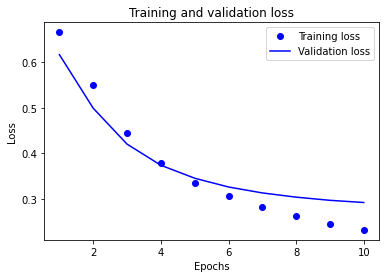

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

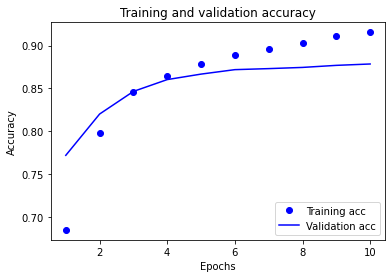

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [46]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test exported model with `raw_test_ds`
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 7ms/step - loss: 0.3106 - accuracy: 0.8736
0.8736400008201599


In [60]:
examples = [
  "This movie was shit.",
  "The movie was the shit.",
  "The movie was terrible...",
  "Great",
  "This movie sucks!",
  "This movie stinks.",
  "This movie stinks!",
  "This movie stinks!!!",
  "This movie smells like feet.",
  "This movie smells like roses.",
  "An excellent film!",
  "The film was perfect.",
  "My favorite film of the decade.",
  "You will feel utterly numb after the screening of The Dark Knight. The film is bleak and brilliant.",
  "Too much psychology and not enough pop. It's possible to be too serious, you know."
]

export_model.predict(examples)

array([[0.50613105],
       [0.52113557],
       [0.37806395],
       [0.6549616 ],
       [0.4380736 ],
       [0.45612943],
       [0.45612943],
       [0.45612943],
       [0.5275625 ],
       [0.54247797],
       [0.6912458 ],
       [0.65376455],
       [0.6999781 ],
       [0.74981236],
       [0.42046285]], dtype=float32)